In [2]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import matplotlib.pyplot as plt
import glob
from rasterio.plot import plotting_extent
from rasterio.merge import merge

## Path of the tiles folder

In [4]:

tiles_dir = "/home/jaipur-ml/Roushan_project/new_project/data/tiles"

In [18]:
files = sorted([os.path.join(tiles_dir, f) 
                for f in os.listdir(tiles_dir) 
                if f.lower().endswith(".tif")])

print("Found", len(files), "images")

Found 10 images


# plotted all the tiles 

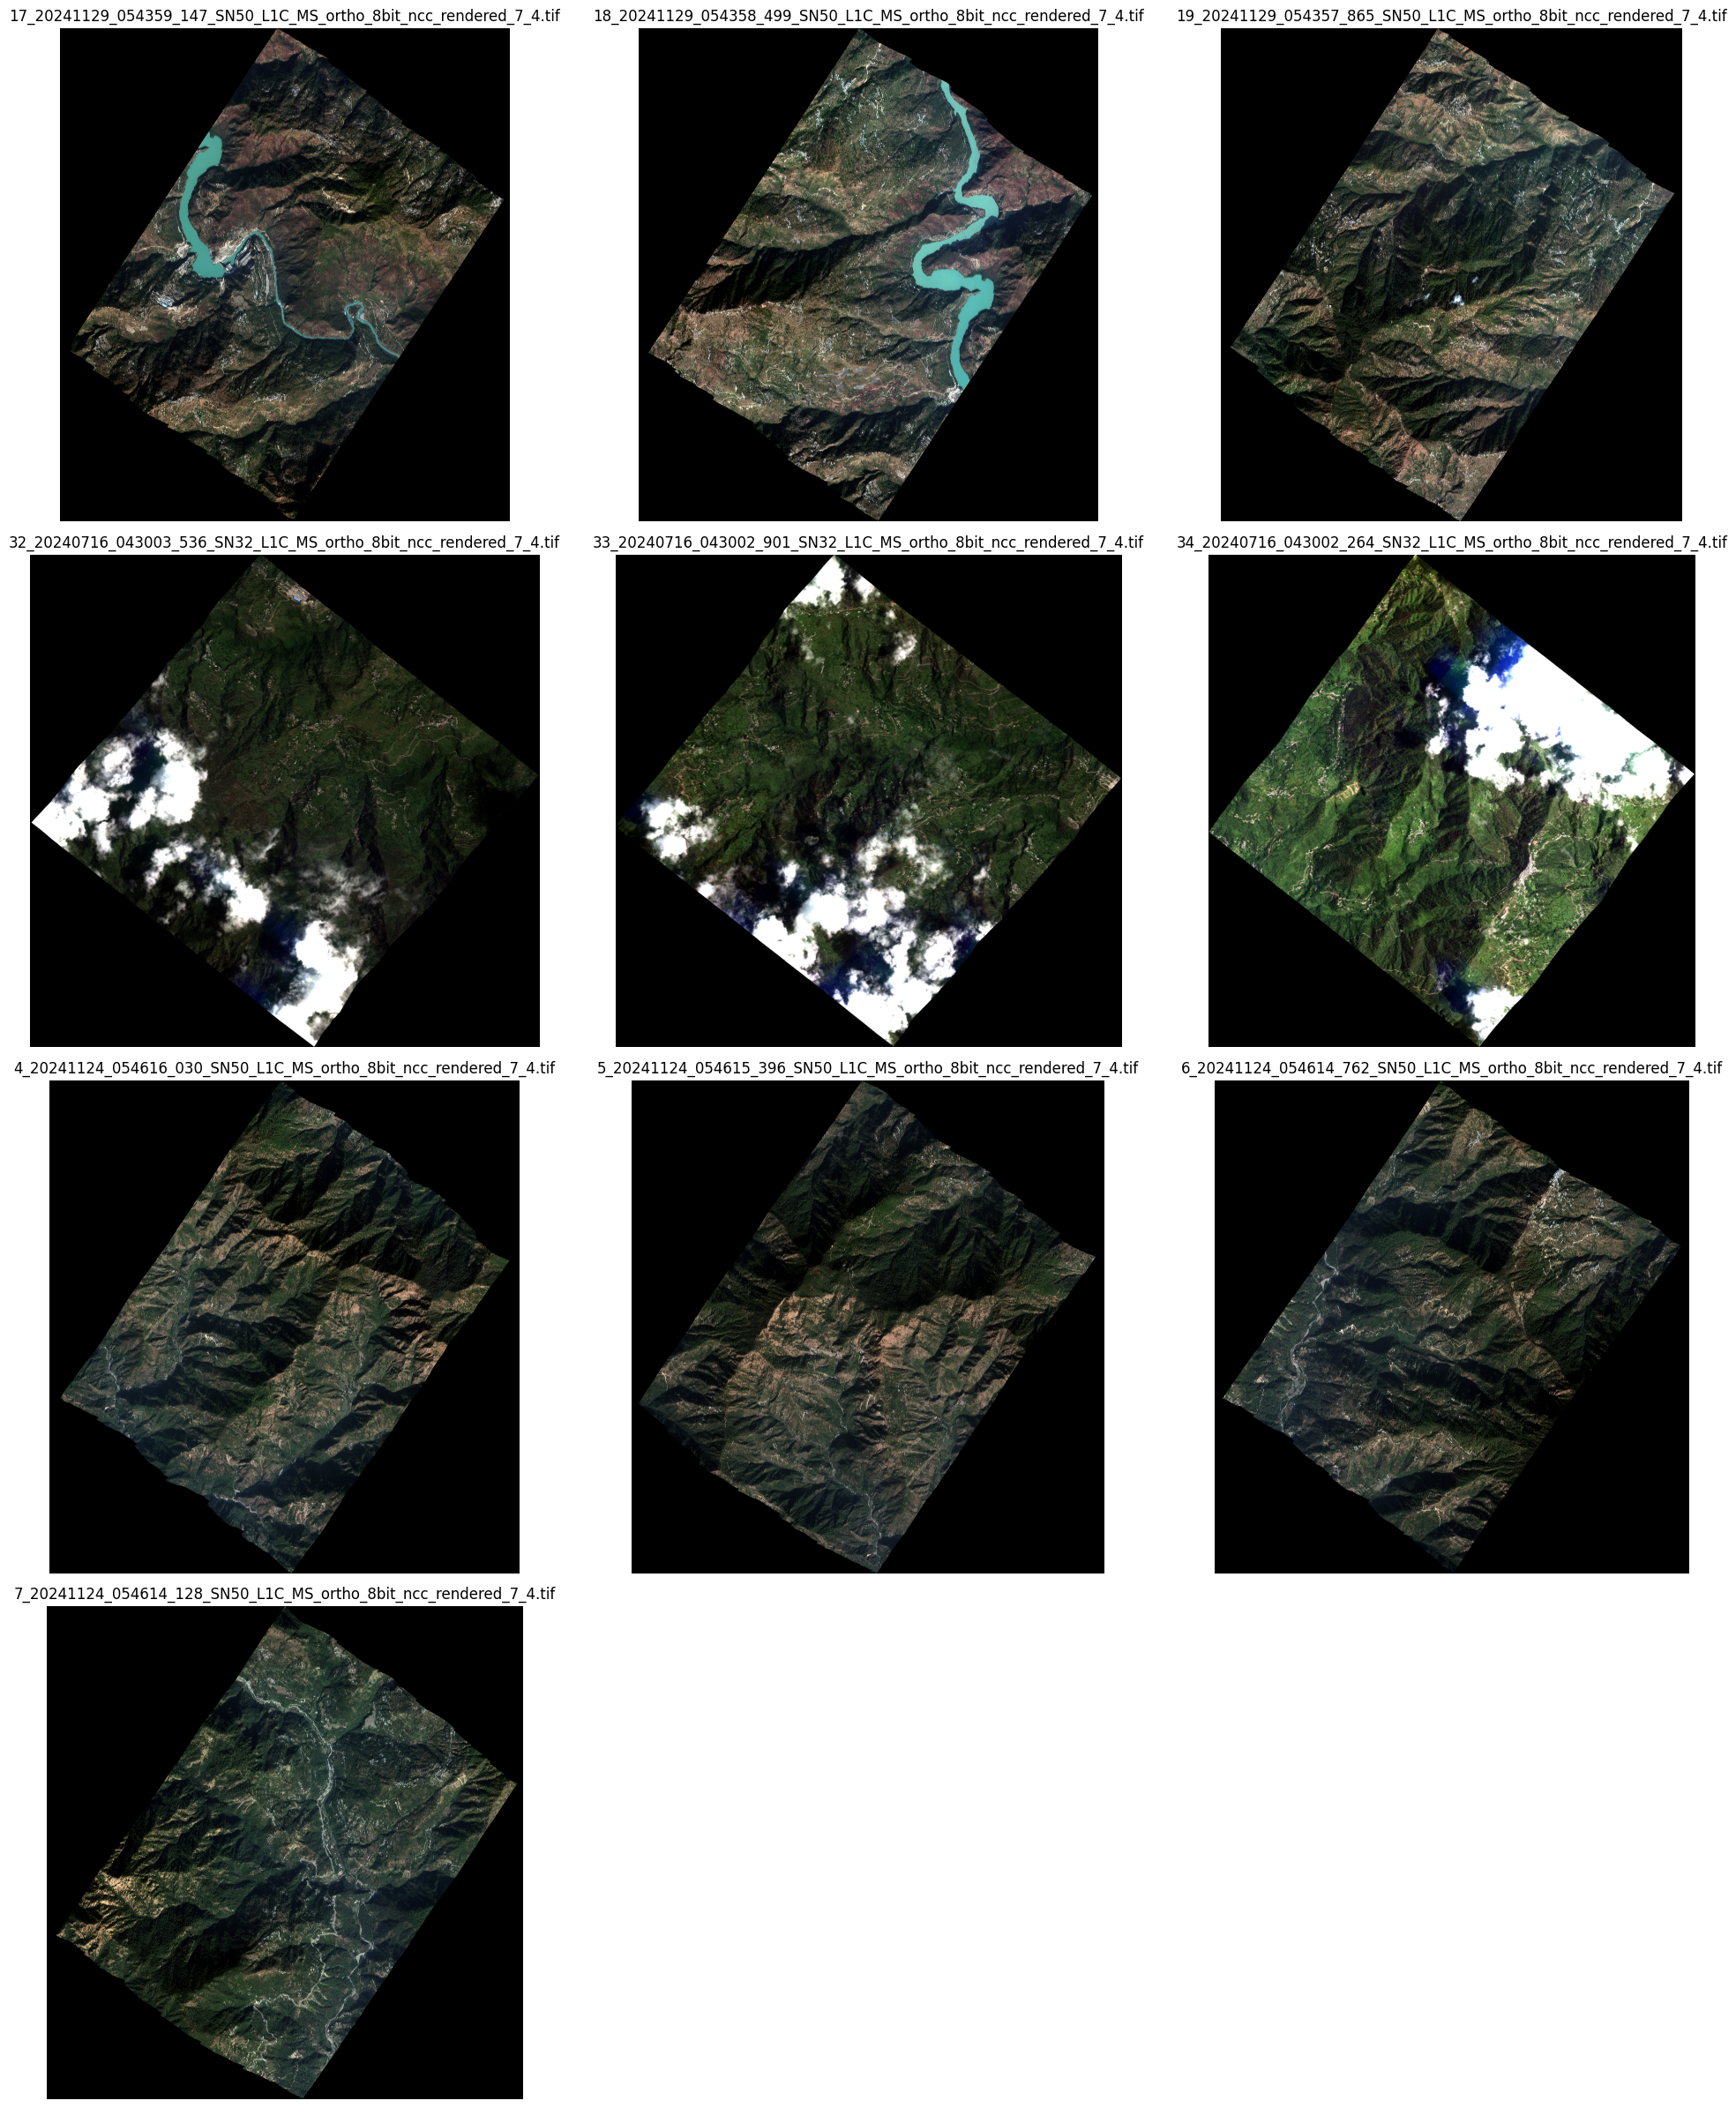

In [ ]:

cols = 3
rows = (len(files) + cols - 1) // cols

plt.figure(figsize=(20, rows * 6))

for i, fp in enumerate(files):
    with rasterio.open(fp) as src:
        img = src.read()

        # If RGB available
        if img.shape[0] >= 3:
            rgb = np.moveaxis(img[:3], 0, -1)
            rgb = np.clip(rgb / 255.0, 0, 1)  # scale
        else:
            rgb = img[0]

    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(rgb)
    ax.set_title(os.path.basename(fp))
    ax.axis("off")

plt.tight_layout()
plt.show()


# Image boundaries
This cell uses the Rasterio library to visualize the geographic boundaries of each tile. By extracting the bounding coordinates from every .tif file and plotting them as red polygon outlines.

/home/jaipur-ml/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


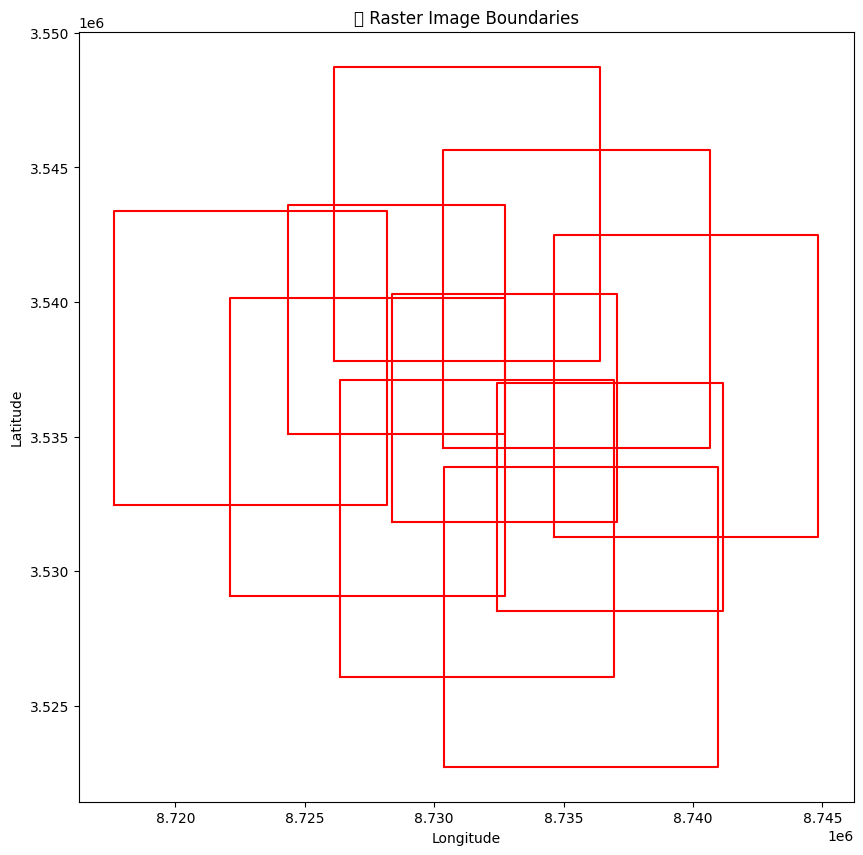

In [ ]:


plt.figure(figsize=(10, 10))

for path in glob.glob("data/tiles/*.tif"):
    with rasterio.open(path) as src:
        bounds = src.bounds
        extent = plotting_extent(src)
        plt.plot(
            [bounds.left, bounds.right, bounds.right, bounds.left, bounds.left],
            [bounds.bottom, bounds.bottom, bounds.top, bounds.top, bounds.bottom],
            color='red'
        )

plt.title("Raster Image Boundaries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [9]:

import os, math
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds
from rasterio.windows import from_bounds as win_from_bounds, Window
from scipy.ndimage import gaussian_filter, binary_dilation
from tqdm import tqdm
import matplotlib.pyplot as plt


In [7]:

out_path  = "/home/jaipur-ml/Roushan_project/new_project/cloudless_mosaic.tif"


# Parameters
* SMOOTH_SIGMA - Controls how much the overlap region is smoothed during seam blending.
* SEAM_K - Determines how strongly the blending reacts to differences between tiles.
* MIN_OVERLAP_PIXELS- Sets the minimum overlap size needed before applying seam blending.

In [10]:
smooth_sigma = 3.0
seam_k = 2.8
min_overlap_pixels = 80


In [11]:

files = sorted([
    os.path.join(tiles_dir, f)
    for f in os.listdir(tiles_dir)
    if f.lower().endswith(".tif")
])

if len(files) == 0:
    raise SystemExit("No .tif files found in tiles_dir")

files[:5], len(files)


(['/home/jaipur-ml/Roushan_project/new_project/data/tiles/17_20241129_054359_147_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif',
  '/home/jaipur-ml/Roushan_project/new_project/data/tiles/18_20241129_054358_499_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif',
  '/home/jaipur-ml/Roushan_project/new_project/data/tiles/19_20241129_054357_865_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif',
  '/home/jaipur-ml/Roushan_project/new_project/data/tiles/32_20240716_043003_536_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif',
  '/home/jaipur-ml/Roushan_project/new_project/data/tiles/33_20240716_043002_901_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif'],
 10)

This cell determines the total geographic area they cover, calculates the required output mosaic size based on the tile resolution, and prepares the transformation needed to correctly place all tiles into a single aligned mosaic.

In [12]:


with rasterio.open(files[0]) as s0:
    ref_crs = s0.crs
    ref_res = s0.res
    bands = s0.count

bounds = [rasterio.open(f).bounds for f in files]

minx = min(b.left for b in bounds)
miny = min(b.bottom for b in bounds)
maxx = max(b.right for b in bounds)
maxy = max(b.top for b in bounds)

resx, resy = ref_res
width = int(math.ceil((maxx - minx) / resx))
height = int(math.ceil((maxy - miny) / abs(resy)))

out_transform = from_bounds(minx, miny, maxx, maxy, width, height)



In [13]:

profile = {
    "driver":"GTiff",
    "height":height,
    "width":width,
    "count":bands,
    "dtype":"uint8",
    "compress":"lzw",
    "crs":ref_crs,
    "transform":out_transform
}

print("Mosaic Size:", height, "x", width)


Mosaic Size: 27803 x 29088


In [14]:

with rasterio.open(out_path, "w", **profile) as dst:
    pass

print("Created:", out_path)


Created: /home/jaipur-ml/Roushan_project/new_project/cloudless_mosaic.tif


This function detects cloudy regions in an image by identifying bright or bluish-white pixels and then expands the detected cloud areas using binary dilation to create a smoother and more complete cloud mask.

In [ ]:


def cloud_mask(img):
    r = img[0].astype(np.int16)
    g = img[1].astype(np.int16)
    b = img[2].astype(np.int16)
    
    bright = r + g + b

    base_cloud = ((r > 180) & (g > 180) & (b > 180)) | (bright > 600)
    bluish_cloud = (b > 150) & (g > 140) & (r > 120)

    mask = (base_cloud | bluish_cloud).astype(np.float32)

    mask = binary_dilation(mask, iterations=2).astype(np.float32)

    return mask


# Multiple functions are happening in this cell

* **Tile Positioning in Mosaic** – Each tile’s geographic bounds are read, and its correct position inside the final mosaic is calculated.

* **Reprojecting Tiles** – Every tile is reprojected into the mosaic’s coordinate system so that all tiles align perfectly.

* **Cloud Detection and Cleaning** – A cloud mask is created for each tile, and cloudy pixels are removed or down-weighted before placement.

* **Overlap Handling** – The code checks where the new tile overlaps with already-written mosaic areas and decides whether to paste or blend.

* **Seam Blending Between Tiles** – In overlap regions, the code blends the new tile with existing pixels using smooth weighting to remove visible seams and create a uniform mosaic.


In [ ]:


with rasterio.open(out_path, "r+") as dst:

    for fp in tqdm(files, desc="Processing Tiles"):
        with rasterio.open(fp) as src:

            tb = src.bounds
            il = max(minx, tb.left)
            ir = min(maxx, tb.right)
            ib = max(miny, tb.bottom)
            it = min(maxy, tb.top)

            if not (il < ir and ib < it):
                continue

            win = win_from_bounds(il, ib, ir, it, transform=out_transform)
            row_off = int(win.row_off); col_off = int(win.col_off)
            h = int(win.height);       w = int(win.width)

            if h <= 0 or w <= 0:
                continue

            window = Window(col_off, row_off, w, h)
            temp = np.zeros((bands, h, w), dtype=np.uint8)

            dst_left, dst_bottom, dst_right, dst_top = rasterio.windows.bounds(window, out_transform)
            dst_trans = from_bounds(dst_left, dst_bottom, dst_right, dst_top, w, h)

            # Reproject each band
            for b in range(1, bands + 1):
                buf = np.zeros((h, w), dtype=np.float32)
                reproject(
                    rasterio.band(src, b), buf,
                    src_transform=src.transform, src_crs=src.crs,
                    dst_transform=dst_trans,   dst_crs=ref_crs,
                    resampling=Resampling.bilinear
                )
                temp[b-1] = np.clip(buf, 0, 255)

            tile_valid = temp.sum(axis=0) > 0
            if tile_valid.sum() < 10: continue

            # Cloud removal
            cm = cloud_mask(temp)
            mask_clear = 1 - gaussian_filter(cm, sigma=1.2)
            usable = (mask_clear * tile_valid).astype(np.float32)

            # Read current mosaic
            existing = dst.read(window=window)
            existing_valid = existing.sum(axis=0) > 0

            if existing_valid.sum() == 0:
                dst.write((temp * (usable > 0)).astype(np.uint8), window=window)
                continue

            overlap = (usable > 0) & existing_valid
            non_overlap = (usable > 0) & (~existing_valid)

            if overlap.sum() < min_overlap_pixels:
                final = existing.copy()
                for b in range(bands):
                    final[b][non_overlap] = temp[b][non_overlap]
                dst.write(final.astype(np.uint8), window=window)
                continue

            # Seam blending
            diff = np.sum((existing.astype(np.float32) - temp.astype(np.float32))**2, axis=0)
            diff_s = gaussian_filter(diff, sigma=smooth_sigma)

            if diff_s.max() != diff_s.min():
                diff_n = (diff_s - diff_s.min()) / (diff_s.max() - diff_s.min())
            else:
                diff_n = diff_s * 0

            weight = np.exp(-seam_k * diff_n) * usable
            if weight.max() > 0:
                weight /= weight.max()

            weight = gaussian_filter(weight, sigma=2)
            weight = np.clip(weight, 0, 1)

            final = existing.astype(np.float32)
            for b in range(bands):
                final[b][overlap] = (
                    weight[overlap] * temp[b][overlap] +
                    (1 - weight[overlap]) * existing[b][overlap]
                )
                final[b][non_overlap] = temp[b][non_overlap]

            dst.write(np.clip(final, 0, 255).astype(np.uint8), window=window)

print("Mosaic Completed:", out_path)


Processing Tiles: 100%|██████████| 10/10 [02:13<00:00, 13.39s/it]


Mosaic Completed: /home/jaipur-ml/Roushan_project/new_project/final_seamless_image_22.tif


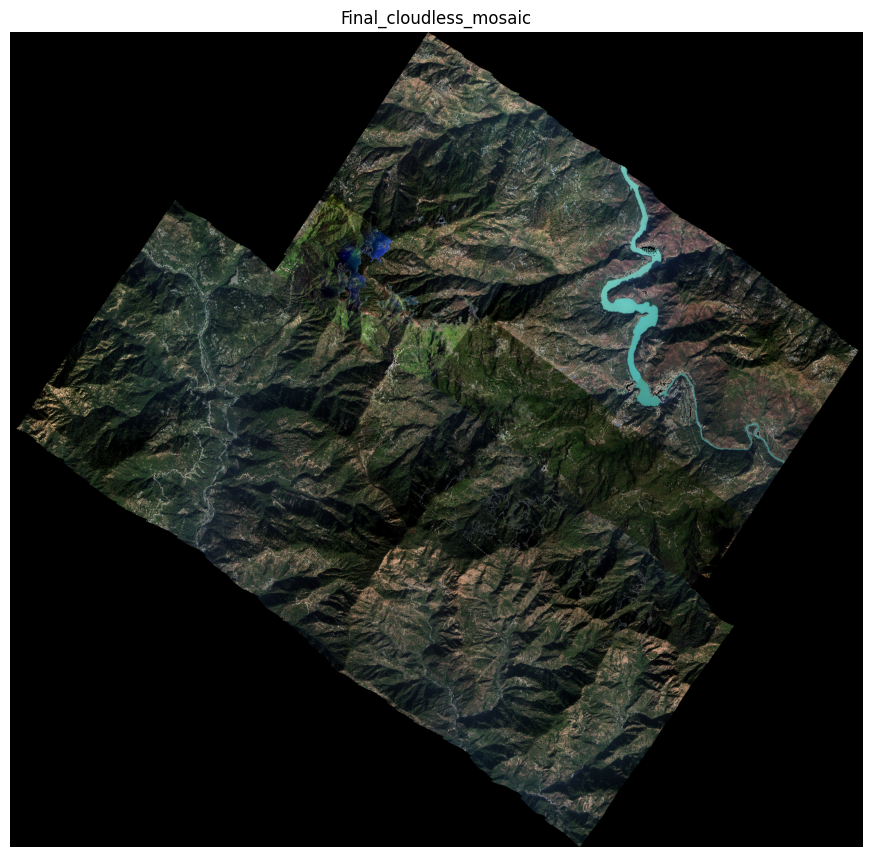

In [5]:


with rasterio.open(out_path) as out:
    factor = max(1, int(max(out.height, out.width) / 2000))
    H = max(1, out.height // factor)
    W = max(1, out.width  // factor)

    arr = out.read(out_shape=(out.count, H, W))
    rgb = np.moveaxis(arr[:3], 0, 2)

plt.figure(figsize=(11,11))
plt.imshow(rgb)
plt.axis("off")
plt.title("Final_cloudless_mosaic")
plt.show()
